In [108]:
import pandas as pd
import numpy as np
import sklearn
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import graphviz

In [109]:
dataset = pd.read_csv("concrete_miss.csv")

In [110]:
dataset

,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Age,ConcreteCompressiveStrength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,NaN,0.0,192.0,0.0,978.4,825.5,360,44.296075
...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.284354
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.178794
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.696601
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.768036


In [111]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Cement                       988 non-null    float64
 1   BlastFurnaceSlag             973 non-null    float64
 2   FlyAsh                       1030 non-null   float64
 3   Water                        1030 non-null   float64
 4   Superplasticizer             1030 non-null   float64
 5   CoarseAggregate              1030 non-null   float64
 6   FineAggregate                1030 non-null   float64
 7   Age                          1030 non-null   int64  
 8   ConcreteCompressiveStrength  1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


In [112]:
dataset.isnull().sum()

Cement                         42
BlastFurnaceSlag               57
FlyAsh                          0
Water                           0
Superplasticizer                0
CoarseAggregate                 0
FineAggregate                   0
Age                             0
ConcreteCompressiveStrength     0
dtype: int64

Turns out that this dataset has 9 columns (including the target variable ConcreteCompressiveStrength) and 1030 rows. Notice that the columns are of float data-type indicating the presence of only continuous features with missing values in the columns of Cement and Blast Furnace Slag.

If you have some missing values such as NA in the dataset you may or may not do a separate treatment for them, because XGBoost is capable of handling missing values internally. You can check out this [link](https://github.com/dmlc/xgboost/issues/21) if you wish to know more on this.

In [113]:
dataset.describe()

,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Age,ConcreteCompressiveStrength
count,988.000000,973.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,280.736063,73.633515,54.187136,181.566359,6.203112,972.918592,773.578883,45.662136,35.817836
std,104.520393,86.586068,63.996469,21.355567,5.973492,77.753818,80.175427,63.169912,16.705679
min,102.000000,0.000000,0.000000,121.750000,0.000000,801.000000,594.000000,1.000000,2.331808
25%,192.000000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.707115
50%,272.800000,22.000000,0.000000,185.000000,6.350000,968.000000,779.510000,28.000000,34.442774
75%,350.000000,142.500000,118.270000,192.000000,10.160000,1029.400000,824.000000,56.000000,46.136287
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.599225


You will build the model using Trees as base learners (which are the default base learners) using XGBoost's scikit-learn compatible API. Along the way, you will also learn some of the common tuning parameters which XGBoost provides in order to improve the model's performance, and using the root mean squared error (RMSE) performance metric to check the performance of the trained model on the test set. Root mean Squared error is the square root of the mean of the squared differences between the actual and the predicted values. As usual, you start by importing the library xgboost and other important libraries that you will be using for building the model.

Separate the target variable and rest of the variables using .iloc to subset the data.

In [114]:
X = dataset.iloc[:,0:8]
y = dataset.iloc[:,8]

Now you will convert the dataset into an optimized data structure called Dmatrix that XGBoost supports and gives it acclaimed performance and efficiency gains.

In [115]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

Now, you will create the train and test set for cross-validation of the results using the train_test_split function from sklearn's model_selection module with test_size size equal to 20% of the data. Also, to maintain reproducibility of the results, a random_state is also assigned.

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

The next step is to instantiate an XGBoost regressor object by calling the XGBRegressor() class from the XGBoost library with the hyper-parameters passed as arguments. For classification problems, you would have used the XGBClassifier() class.

In [117]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

Fit the regressor to the training set and make predictions on the test set using the familiar .fit() and .predict() methods.

In [118]:
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

[19:50:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Compute the rmse by invoking the mean_sqaured_error function from sklearn's metrics module.

In [119]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 18.599553


Well, you can see that your RMSE for the price prediction came out to be around 18.6 per MPa.

This time you will create a hyper-parameter dictionary params which holds all the hyper-parameters and their values as key-value pairs but will exclude the n_estimators from the hyper-parameter dictionary because you will use num_boost_rounds instead.

You will use these parameters to build a 3-fold cross validation model by invoking XGBoost's cv() method and store the results in a cv_results DataFrame. Note that here you are using the Dmatrix object you created before.

In [120]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

[19:50:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:50:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:50:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


cv_results contains train and test RMSE metrics for each boosting round.

In [121]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,35.729394,0.053049,35.750604,0.150151
1,32.716952,0.084704,32.748302,0.188196
2,30.040654,0.056978,30.127120,0.266205
3,27.614394,0.159974,27.717504,0.270462
4,25.461283,0.125358,25.589998,0.269885


Extract and print the final boosting round metric.

In [122]:
print((cv_results["test-rmse-mean"]).tail(1))

49    7.497369
Name: test-rmse-mean, dtype: float64


You can see that your RMSE for the price prediction has reduced as compared to last time and came out to be around 7.5 per MPa. You can reach an even lower RMSE for a different set of hyper-parameters. You may consider applying techniques like Grid Search, Random Search and Bayesian Optimization to reach the optimal set of hyper-parameters.

You can also visualize individual trees from the fully boosted model that XGBoost creates using the entire housing dataset. XGBoost has a plot_tree() function that makes this type of visualization easy. Once you train a model using the XGBoost learning API, you can pass it to the plot_tree() function along with the number of trees you want to plot using the num_trees argument.

In [123]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

[19:50:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Plotting the first tree with the matplotlib library:

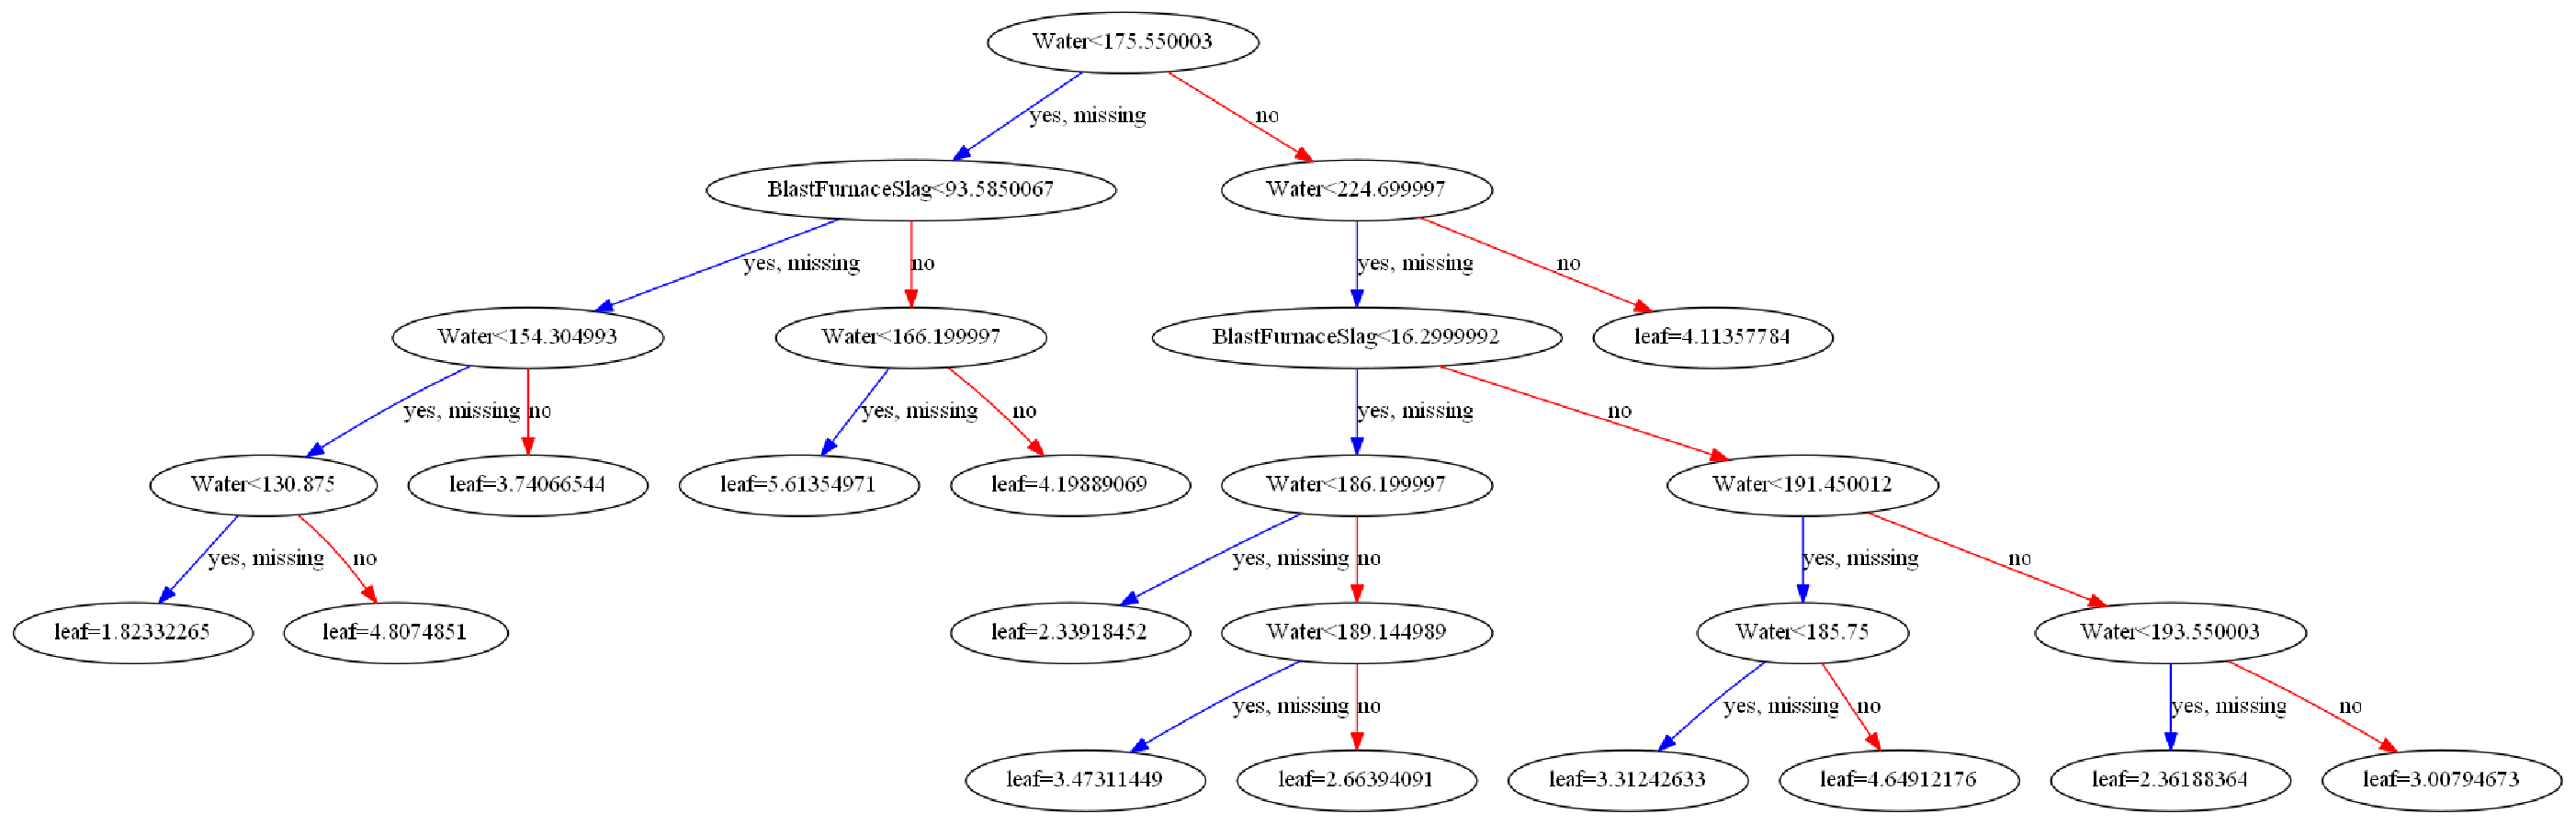

In [130]:
xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = (5,5)
plt.show()

These plots provide insight into how the model arrived at its final decisions and what splits it made to arrive at those decisions.

Another way to visualize your XGBoost models is to examine the importance of each feature column in the original dataset within the model.

One simple way of doing this involves counting the number of times each feature is split on across all boosting rounds (trees) in the model, and then visualizing the result as a bar graph, with the features ordered according to how many times they appear. XGBoost has a plot_importance() function that allows you to do exactly this.

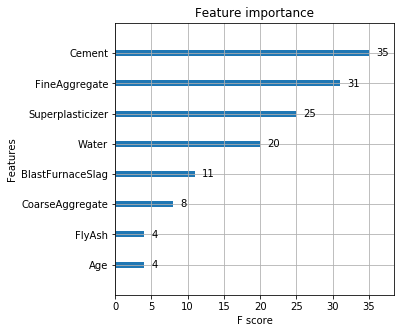

In [131]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = (16,8)
plt.show()

As you can see the feature `Cement` has been given the highest importance score among all the features. Thus XGBoost also gives you a way to do Feature Selection. Isn't this brilliant?

### Comments on Missing values

xgboost naturally accepts sparse feature format, you can directly feed data in as sparse matrix, and only contains non-missing value.

i.e. features that are not presented in the sparse feature matrix are treated as 'missing'. XGBoost will handle it internally and you do not need to do anything on it.

Internally, XGBoost will automatically learn what is the best direction to go when a value is missing. Equivalently, this can be viewed as automatically "learn" what is the best imputation value for missing values based on reduction on training loss.

For continuous features, a missing (default) direction is learnt for missing value data to go into, so when the data of the speficific value is missing, then it goes to the default direction.

### Handling Missing Values

In [19]:
from sklearn.impute import SimpleImputer
import seaborn as sns

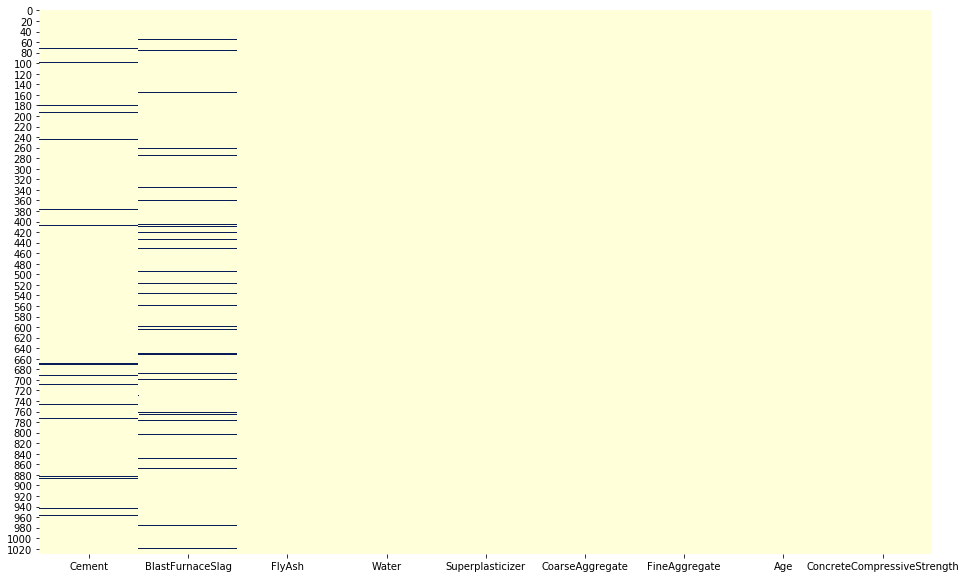

In [20]:
plt.figure(figsize=(16,10))
sns.heatmap(dataset.isnull(), cbar=False, cmap="YlGnBu")

In [21]:
dataset.shape

(1030, 9)

In [22]:
X.shape

(1030, 8)

#### 1. Drop NA's

In [23]:
# drop rows with missing values
dataset.dropna(inplace=True)

In [24]:
# summarize the shape of the data with missing rows removed
print(dataset.shape)

(931, 9)


In [25]:
X = dataset.iloc[:,0:8]
y = dataset.iloc[:,8]

In [26]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [28]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [29]:
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)

[19:48:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [30]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 16.800549


In [31]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

[19:48:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:48:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:48:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [32]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,35.750185,0.438433,35.809781,1.015267
1,32.708033,0.424258,32.773226,0.996156
2,30.037999,0.372105,30.221731,1.011989
3,27.602481,0.449630,27.773001,0.861069
4,25.446522,0.353128,25.653493,0.939127


In [33]:
print((cv_results["test-rmse-mean"]).tail(1))

49    7.618871
Name: test-rmse-mean, dtype: float64


#### 2. Impute NA's

##### 2.1. Replace with mean

In [34]:
dataset = pd.read_csv("concrete_miss.csv")

In [35]:
# fill missing values with mean column values
dataset.fillna(dataset.mean(), inplace=True)
# count the number of NaN values in each column
print(dataset.isnull().sum())

Cement                         0
BlastFurnaceSlag               0
FlyAsh                         0
Water                          0
Superplasticizer               0
CoarseAggregate                0
FineAggregate                  0
Age                            0
ConcreteCompressiveStrength    0
dtype: int64


In [36]:
X = dataset.iloc[:,0:8]
y = dataset.iloc[:,8]

In [37]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [39]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [40]:
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)

[19:48:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [41]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 18.602483


In [42]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

[19:48:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:48:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:48:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [43]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,35.730761,0.051033,35.746958,0.148255
1,32.719807,0.081410,32.732797,0.176922
2,30.043382,0.055011,30.111931,0.254819
3,27.616342,0.158305,27.708154,0.266241
4,25.464361,0.121989,25.575183,0.254666


In [44]:
print((cv_results["test-rmse-mean"]).tail(1))

49    7.50266
Name: test-rmse-mean, dtype: float64


##### 2.2. Impute with median

In [45]:
from sklearn.impute import SimpleImputer
dataset = pd.read_csv("concrete_miss.csv")
# split dataset into inputs and outputs
values = dataset.values
X = values[:,0:8]
y = values[:,8]
# define the imputer
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
# transform the dataset
transformed_values = imputer.fit_transform(values)
# count the number of NaN values in each column
print('Missing: %d' % np.isnan(transformed_values).sum())

Missing: 0


In [46]:
X = transformed_values[:,0:8]
y = transformed_values[:,8]

In [47]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [49]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [50]:
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)

[19:48:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [51]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 18.571478


In [52]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

[19:48:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:48:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:48:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [53]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,35.730761,0.051033,35.746958,0.148255
1,32.719807,0.081410,32.732797,0.176922
2,30.043382,0.055011,30.111931,0.254819
3,27.616342,0.158305,27.708154,0.266241
4,25.463716,0.122796,25.574000,0.253443


In [54]:
print((cv_results["test-rmse-mean"]).tail(1))

49    7.477018
Name: test-rmse-mean, dtype: float64


In [55]:
dataset

,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Age,ConcreteCompressiveStrength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,NaN,0.0,192.0,0.0,978.4,825.5,360,44.296075
...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.284354
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.178794
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.696601
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.768036
